# Objective:

### <font color=red>Check the validity of the New Keynesian Phillips Curve in the Indian Context.</font> 
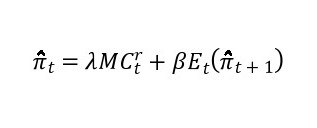
We have inflation data for 1960-2020. We divide this time period into three parts. <br>  Train: 1960-1990  <br> Valid: 1991-2000.   <br> Forecast: 2001-2020 <br>

- Reverse engineer the values of real marginal cost for the 1960-2000. <br>
- On the basis of the calculated values for the train data, predict values for Valid. If it fits well, continue prediction for forecast years. <br>
- Then calculate inflation using NKPC. Check the values of actual inflation against forecasted inflation to examine the validity of the model.

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import datetime
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tsa.stattools import acf, pacf 
warnings.simplefilter("ignore")
import itertools    
from math import sqrt
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

**Import the data and restrict it to the year 2000. We will forecast for  the rest of the years.**

In [57]:
df = pd.read_csv("C:/Users/shrut/OneDrive/Desktop/Masters/Python/InflationData.csv")

In [58]:
df['Year'] = pd.DatetimeIndex(df['observation_date']).year
df = df[df['Year'] < 2001]

**We define beta and lambda as two uniformly distributed parameters.**


In [59]:
beta = np.random.uniform(0.7,1)
lam = np.random.uniform(0,0.1)

**Substituting the values of inflation in periods t and t+1 to get the values of the real marginal cose.**

In [60]:
x= df.Monthly_Rate
z=list()
for i in range(0,len(df.Monthly_Rate)-1):
    y =(x[i]- (beta * x[i+1]))/ lam
    z.append(y)

In [61]:
df1= pd.DataFrame({'mcr':z})
df['mcr']= df1['mcr']

In [62]:
fig= go.Figure()
df=df.round(2)
fig.add_trace(go.Scatter(dict(x=df.observation_date, y=df.Monthly_Rate, mode='lines+markers')))

fig.update_layout(title=go.layout.Title(
        text="Real Marginal Cost (1960-2000)",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="mcr",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

$Ad$ $Dickey$ $Fuller$ $Test$

In [63]:
df.mcr = np.where(np.isnan(df.mcr),0,df.mcr)
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
adf_test(df.mcr)

Results of Dickey-Fuller Test:
Test Statistic                -1.333536e+01
P-value                        6.067458e-25
Number of Lags Used            1.000000e+01
Number of Observations Used    4.810000e+02
Critical Value (1%)           -3.444018e+00
Critical Value (5%)           -2.867568e+00
Critical Value (10%)          -2.569980e+00
dtype: float64


In [64]:
result = adfuller(df['mcr'].dropna())
result

(-13.33536202536133,
 6.067457664434132e-25,
 10,
 481,
 {'1%': -3.4440184853599876,
  '5%': -2.867567599912013,
  '10%': -2.5699804779975883},
 4681.05897230743)

In [65]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -13.335362
p-value: 0.000000


**First order differencing to make the series more stationary**

In [66]:
df.mcr = np.where(np.isnan(df.mcr),0,df.mcr)
X = df.mcr
t=1
diff_1 = list()
for i in range(t, len(X)):
    value = X[i] - X[i - t]
    diff_1.append(value)

fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.observation_date, y=diff_1, mode='lines+markers')))

fig.update_layout(title=go.layout.Title(
        text="First Order Differencing",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="MCR Difference",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

In [67]:
diff_1 = np.where(np.isnan(diff_1), 0, diff_1)
adf_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.387830e+01
P-value                        6.278861e-26
Number of Lags Used            1.500000e+01
Number of Observations Used    4.750000e+02
Critical Value (1%)           -3.444192e+00
Critical Value (5%)           -2.867644e+00
Critical Value (10%)          -2.570021e+00
dtype: float64


*We tried with different order differencing, first order gave us the best results.*

**Dividing the data into two sets, train and valid as mentioned above.**

In [68]:
Train= df.loc[(df['Year'] >= 1960) & (df['Year'] <= 1990)]
Valid= df.loc[(df['Year'] >= 1991)]

In [69]:
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train.mcr, mode='lines+markers', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid.mcr, mode='lines+markers', name= 'Valid')))

fig.update_layout(title=go.layout.Title(
        text="mcr",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="MCR",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

### Checking and eliminating trend  

In [70]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=df.observation_date, y=ts, mode='lines+markers', name= 'Original Data')))
    fig.add_trace(go.Scatter(dict(x=df.observation_date, y=rol_mean, mode='lines', name= 'Rolling Mean',line=dict(color='black', width=2))))
    fig.add_trace(go.Scatter(dict(x=df.observation_date, y=rol_std, mode='lines', name= 'Rolling Standard',line=dict(color='brown', width=2))))

    fig.update_layout(title=go.layout.Title(
        text="Rolling Mean & Standard Deviation",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="mcr",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

    fig.show()

In [71]:
TestStationaryPlot(df["mcr"])

**Plotting the rolling mean and rolling std for the real marginal cost of the whole data. We see a very unstable rolling mean, which suggests a need to make this data stationary.**

In [72]:
Train['First_Diff'] = Train['mcr'] - Train['mcr'].shift(1) 

In [73]:
TestStationaryPlot(Train["mcr"].dropna(inplace=False))
adf_test(Train["mcr"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.356664e+01
P-value                        2.256062e-25
Number of Lags Used            8.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


**Plotting the rolling mean and rolling std for the real marginal cost of the Train data. We see a very unstable rolling mean, which suggests a need to make this data stationary.**

In [74]:
TestStationaryPlot(Train["First_Diff"].dropna(inplace=False))
adf_test(Train["First_Diff"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.285571e+01
P-value                        5.237598e-24
Number of Lags Used            1.400000e+01
Number of Observations Used    3.560000e+02
Critical Value (1%)           -3.448853e+00
Critical Value (5%)           -2.869693e+00
Critical Value (10%)          -2.571114e+00
dtype: float64


**Plotting the rolling mean and rolling std for the real marginal cost of the first order differenciated train data. We see a very that the rolling mean has stabilised, suggesting that this data can be used for trend analysis. The p-value is also very small, hinting towards the suitablility of the data. We would, however, still check the rolling mean of the seasonally differentiated data.**

### Checking and eliminating seasonality

In [75]:
Train['Year'] = pd.DatetimeIndex(Train['observation_date']).year
Train['Month'] = pd.DatetimeIndex(Train['observation_date']).month

In [76]:
df['Year'] = pd.DatetimeIndex(df['observation_date']).year
df['Month'] = pd.DatetimeIndex(df['observation_date']).month

In [77]:
widget = widgets.IntRangeSlider(value=[1974, 2000], min=1960, max=2000, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget

IntRangeSlider(value=(1974, 2000), description='Time Period:', max=2000, min=1960)

In [78]:
# # Prepare data
years = widget.value
years = list(range(years[0],years[1]+1))


# Draw Plot
fig = go.Figure()

for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=df[df['Year']==years[i]].Month.tolist(),
            y=df[df['Year']==years[i]].mcr.round(2).tolist(),
            name=str(years[i])))
#Layout changes
fig.update_layout(title=go.layout.Title(
        text="Seasonal Trend of MCR",
        xref="paper",
        x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="mcr",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
fig.update_yaxes(nticks=10)
   
fig.show()

**It can be seen that the line graphs for multiple years follow similar trends. They move upward/downward at same time and with similar intensity. This shows the <font color=red>presence of seasonality in the data</font>. To understand it better, we find out the rolling mean and rolling std for <br>(a) Seasonal Difference (b) Seasonal First Difference <br>to see which is better for predicting the real MC.**

In [79]:
Train['Seasonal_Diff'] = Train['mcr'] - Train['mcr'].shift(12)  


**Seasonal difference**

In [80]:
TestStationaryPlot(Train["Seasonal_Diff"].dropna(inplace=False))
adf_test(Train["Seasonal_Diff"].dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -5.276583
P-value                          0.000006
Number of Lags Used             11.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


**The rolling mean is more stable than the train data, but not as much as the first order differentiated data.**

In [81]:
Train['Seasonal_First_Diff'] = Train['mcr'] - Train['mcr'].shift(1)

**Seasonal First Difference**

In [82]:
TestStationaryPlot(Train["Seasonal_First_Diff"].dropna(inplace=False))
adf_test(Train["Seasonal_First_Diff"].dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -1.285571e+01
P-value                        5.237598e-24
Number of Lags Used            1.400000e+01
Number of Observations Used    3.560000e+02
Critical Value (1%)           -3.448853e+00
Critical Value (5%)           -2.869693e+00
Critical Value (10%)          -2.571114e+00
dtype: float64


**As stationary as the first order differentiated data (p-value is extremely close). Better in the sense that it takes care of the seasonality.**

### Seasonal Decomposition of Data

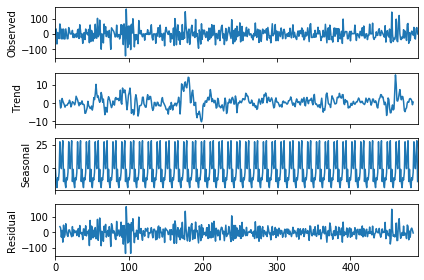

In [83]:
result = seasonal_decompose(df['mcr'].dropna(), model='additive', freq =12)
result.plot()
plt.show()

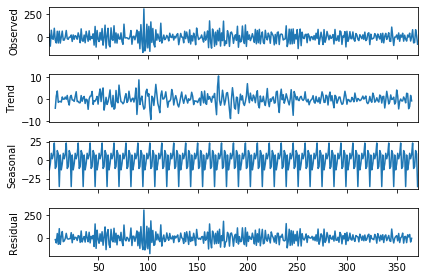

In [84]:
result = seasonal_decompose(Train['First_Diff'].dropna(), model='additive', freq =12)
result.plot()
plt.show()

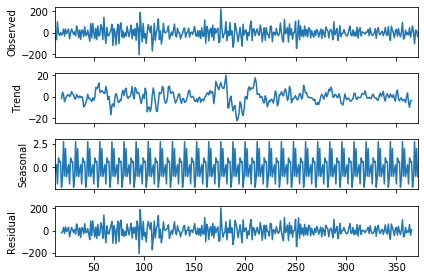

In [85]:
result = seasonal_decompose(Train['Seasonal_Diff'].dropna(), model='additive', freq =12)
result.plot()
plt.show()

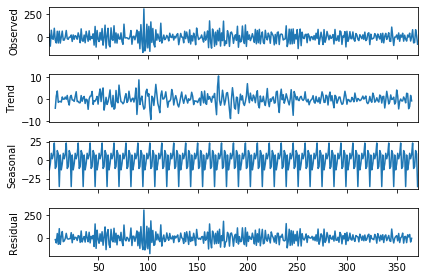

In [86]:
result = seasonal_decompose(Train['Seasonal_First_Diff'].dropna(), model='additive', freq =12)
result.plot()
plt.show()

**We observe that the intensity of the seasonal trend has dampened as we've progressed. It was the most in the original data, slightly less is first difference of the Train data, and even lesser in seasonal first difference of the Train data set. We can make these claims by observing that the cycles are getting more spaced out.**

### Predicting for years 1990-2000

In [87]:
Train.Seasonal_First_Diff=np.where(np.isnan(Train.Seasonal_First_Diff), 0, Train.Seasonal_First_Diff)

In [88]:
y_hat_avg = Valid.copy() 
fit1= fit1 = sm.tsa.statespace.SARIMAX(Train.Seasonal_First_Diff.dropna(), order=(1,0,1), seasonal_order=(1,0,1,12)).fit() 
print(fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                Seasonal_First_Diff   No. Observations:                  372
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1858.849
Date:                            Thu, 14 May 2020   AIC                           3727.698
Time:                                    17:33:55   BIC                           3747.293
Sample:                                         0   HQIC                          3735.480
                                            - 372                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3822      0.038     -9.989      0.000      -0.457      -0.307
ma.L1         -0.9992      0.124   

**The hypotheses for the Ljung - Box test are:**

𝐻𝐻0 : Residual is white noise
𝐻𝐻1 : Residual is not white noise

**The “residuals” in a time series model are what is left over after fitting a model. Residuals are useful in checking whether a model has adequately captured the information in the data.**

**The hypotheses for the Jarque-Bera test are:**

𝐻𝐻0 : The series is normally distributed
𝐻𝐻1 : The series is not normally distributed


**The hypotheses for the Heteroskedasticity test are:**

𝐻𝐻0 : Model is homoskedastic
𝐻𝐻1 : Model is Heteroskedastic

**The p-value of all the parameters is '0' implying that the regression is significant.**


1. The p-value of the Ljung - Box test is '0' implying that we are unable to reject the null hypothesis, i.e. <font color=red>the residual is white noise</font>. A white noise process is a random process of residuals that are uncorrelated, have mean zero, and a finite variance.


2. Similarly, the p-value of the Jarque bera test is '0' implying that we are unable to reject the null hypothesis, i.e. <font color=red>the data is indeed normally distributed.</font>


3. The p-value of the test for Heteroskedasticity is '0' implying that we are unable to reject the null hypothesis, i.e. <font color=red>the variance of the error term is constant across all values of the independent variables.</font>


4. Therefore, the residuals are white noise, data is normally distributed, and <font color=red>the model has constant error variance</font>, all of which are ideal conditions.

In [89]:
y_hat_avg['SARIMA'] = fit1.predict(start=372, end=491, dynamic=True)

In [90]:
Valid.mcr=np.where(np.isnan(Valid.mcr), 0, Valid.mcr)
rms = sqrt(mean_squared_error(Valid.mcr.dropna(), y_hat_avg.SARIMA.dropna())) 
print(rms)

34.16014984031666


In [91]:
Valid['Predicted'] = y_hat_avg['SARIMA']

In [92]:
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train["mcr"], mode='lines', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid['mcr'], mode='lines', name= 'Valid')))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid['Predicted'], mode='lines', name= 'Predicted')))


fig.update_layout(title=go.layout.Title(
        text="SARIMA Prediction of mcr",
        xref="paper",x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="mcr",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

**The green part shows the predicted mcr for years 1990-2000. The red part is the original calculated mcr from the NKPC equation. The graph shows how good the predicted mcr is for the calculated mcr, indicating whether or not to use this model for further forecast.**

### Forecasted MCR (2000-2020)

In [93]:
p = fit1.predict(start=493, end=720, dynamic=True)

**p is the forecasted value of MCR for years 2001-2020.** <br> 
**We are now creating a dataframe for all the dates from 1960-2020.**

In [94]:
rng = pd.date_range('1960-01-01', periods=719, freq='M')
df_new = pd.DataFrame({ 'Date': rng}) 


**Merging the two dataframes (original and the newly created date data frame)**

In [95]:
df_new['mcr']= df['mcr']

*We create a series of zeros (called zero_) and merge it with the new forecast series p to make a single series. <br> We convert this series into a dataframe and add this to the newly created date frame. Now we have a dataframe which has dates from 1960 and mcr forecast for the 20 years (we have put zero in place of all the mcr values before 2000) .*

In [96]:
zero = pd.Series(0)
zero_ =  pd.Series(zero.repeat(491))
c = zero_.append(p)
df_1 =c.to_frame(name = 'forecast')

In [109]:
df_1 = df_1.reset_index()
df_new['forecast'] = df_1['forecast']

In [112]:
df_new.mcr = np.where(np.isnan(df_new.mcr), 0, df_new.mcr)
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.observation_date, y=df["mcr"], mode='lines', name= 'Estimated')))
fig.add_trace(go.Scatter(dict(x=df_new.Date, y=df_new['forecast'], mode='lines', name= 'Forecasted')))


fig.update_layout(title=go.layout.Title(
        text="SARIMA Forecast of mcr",
        xref="paper",x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="mcr",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

**Here er have plotted <font color=blue>originally calculated mcr</font> and the <font color=red>mcr forecast</font>.**

### Calculating inflation using the forecasted MCR values<br> 
**We now add inflation rates to the dataframe df_new and take values later than year 2000.**

In [99]:
df_new['inflation'] = df['Monthly_Rate']
df_new= df_new[491:]
df_new['inflation']=df_new['inflation'].replace(np.nan,0)

**Using the NKPC formula to find expected inflation for the 20 years (forecast period).**

In [101]:
for i in range(491, 717):
    df_new.loc[i+1,'inflation'] = [df_new.loc[i,'inflation'] - (lam * df_new.loc[i,'forecast'])] 

In [102]:
for i in range(492, 718):
    df_new.loc[i,'inflation'] = (df_new.loc[i,'inflation'])/ beta 

**Importing original data to plot against the forecast data**

In [103]:
data = pd.read_csv("C:/Users/shrut/OneDrive/Desktop/Masters/Python/InflationData.csv")

In [104]:
data['Year'] = pd.DatetimeIndex(data['observation_date']).year
data = data.loc[491:]

In [105]:
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=data['Monthly_Rate'], mode='lines', name= 'Actual Inflation')))
    fig.add_trace(go.Scatter(dict(x=df_new.Date, y=df_new['inflation'], mode='lines', name= 'Forecasted',line=dict(width=2))))

    fig.update_layout(title=go.layout.Title(
            text="Actual vs forecasted inflation",
            xref="paper",x=0),
            margin=dict(l=10, r=0, t=50, b=50),
            xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time",font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"))),
            yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="inflation",font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"))))

    fig.show()

**We see that <font color=red>inflation forecast </font> values are always below the <font color=blue>original inflation</font>. The trend we see here does not exactly match with the orginal values. This shows that we do not get a good fit of the NKPC for India.**